In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('sortedGameLogs.csv')
df=df.drop(columns='Unnamed: 0')
df[['PLAYER_ID','GAME_ID','PTS', 'REB', 'AST', 'MIN', 'FGA', 'FG3A', 'FTA', 'STL','BLK','TOV']].head(),df[['PLAYER_ID','GAME_ID','PTS', 'REB', 'AST', 'MIN', 'FGA', 'FG3A', 'FTA', 'STL','BLK', 'TOV']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26401 entries, 0 to 26400
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PLAYER_ID  26401 non-null  int64  
 1   GAME_ID    26401 non-null  int64  
 2   PTS        26401 non-null  int64  
 3   REB        26401 non-null  int64  
 4   AST        26401 non-null  int64  
 5   MIN        26401 non-null  float64
 6   FGA        26401 non-null  int64  
 7   FG3A       26401 non-null  int64  
 8   FTA        26401 non-null  int64  
 9   STL        26401 non-null  int64  
 10  BLK        26401 non-null  int64  
 11  TOV        26401 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.4 MB


(   PLAYER_ID   GAME_ID  PTS  REB  AST        MIN  FGA  FG3A  FTA  STL  BLK  \
 0       2544  22300015   32   11    6  36.383333   17     4   11    1    1   
 1       2544  22300026   16    9    6  22.650000   11     6    2    1    0   
 2       2544  22300036   35    5    9  34.533333   22     9    6    2    0   
 3       2544  22300042   17    7    9  24.016667   10     5    2    0    0   
 4       2544  22300061   21    8    5  29.010000   16     4    1    1    0   
 
    TOV  
 0    4  
 1    4  
 2    3  
 3    2  
 4    0  ,
 None)

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
def prepare_multi_player_sequences(df, features, sequence_length, min_games_per_player=10):
    """
    Prepare time series sequences for multiple players
    
    Args:
    - df: DataFrame with player game-level data
    - features: List of feature columns to use
    - sequence_length: Number of previous games to use for prediction
    - min_games_per_player: Minimum games a player must have to be included
    
    Returns:
    - X: Input sequences
    - y: Target sequences
    - scaler: Feature scaler
    """
    # Sort data chronologically for each player
    df_sorted = df.sort_values(['PLAYER_ID', 'GAME_ID'])
    
    # Filter players with sufficient game history
    player_game_counts = df_sorted['PLAYER_ID'].value_counts()
    valid_players = player_game_counts[player_game_counts >= min_games_per_player].index
    
    df_filtered = df_sorted[df_sorted['PLAYER_ID'].isin(valid_players)]
    
    # Standardize features across ALL players
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_filtered[features])
    
    # Prepare sequences
    sequences_X, sequences_y = [], []
    
    for player_id in valid_players:
        player_data = scaled_features[df_filtered['PLAYER_ID'] == player_id]
        
        # Create sequences for this player
        for i in range(len(player_data) - sequence_length):
            sequences_X.append(player_data[i:i+sequence_length])
            sequences_y.append(player_data[i+sequence_length])
    
    return (np.array(sequences_X), 
            np.array(sequences_y), 
            scaler)

def create_lstm_model(sequence_length, num_features):
    """
    Create LSTM model for time series prediction
    
    Args:
    - sequence_length: Number of time steps in input sequence
    - num_features: Number of features to predict
    
    Returns:
    - Compiled Keras model
    """
    model = Sequential([
        LSTM(64, 
             input_shape=(sequence_length, num_features), 
             return_sequences=True,
             activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_features)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

def train_time_series_model(X, y, test_size=0.2, epochs=100):
    """
    Train and evaluate time series model
    
    Args:
    - X: Input sequences
    - y: Target sequences
    - test_size: Proportion of data for validation
    - epochs: Maximum training epochs
    
    Returns:
    - Trained model
    - Training history
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    
    # Model and callbacks
    model = create_lstm_model(X.shape[1], X.shape[2])
    
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=0.00001
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return model, history

In [7]:
features = ['PTS', 'REB', 'AST', 'MIN', 'FGA', 'FG3A', 'FTA','STL','BLK', 'TOV']
sequence_length = 5

In [9]:
# Prepare sequences
X, y, scaler = prepare_multi_player_sequences(
    df, 
    features=features, 
    sequence_length=sequence_length,
    min_games_per_player=20  # Adjust based on your dataset
)

In [11]:
# Train model
model, history = train_time_series_model(X, y)

Epoch 1/100


/Users/jamesstevens/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


576/576 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9976 - mae: 0.7583 - val_loss: 0.4403 - val_mae: 0.5067 - learning_rate: 0.0010
Epoch 2/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7235 - mae: 0.6441 - val_loss: 0.4432 - val_mae: 0.5123 - learning_rate: 0.0010
Epoch 3/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6942 - mae: 0.6331 - val_loss: 0.4384 - val_mae: 0.5149 - learning_rate: 0.0010
Epoch 4/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6845 - mae: 0.6282 - val_loss: 0.4341 - val_mae: 0.5063 - learning_rate: 0.0010
Epoch 5/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6795 - mae: 0.6238 - val_loss: 0.4363 - val_mae: 0.5058 - learning_rate: 0.0010
Epoch 6/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6795 - mae: 0.6261 - val_loss: 0.4338 - val_mae: 0.5041 - learning_rate: 0.0010
Epoch 7/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6780 - mae: 0.6243 - val_loss: 0.4253 - val_mae: 0.4894 - learning_rate: 0.0010
Epoch 8/100

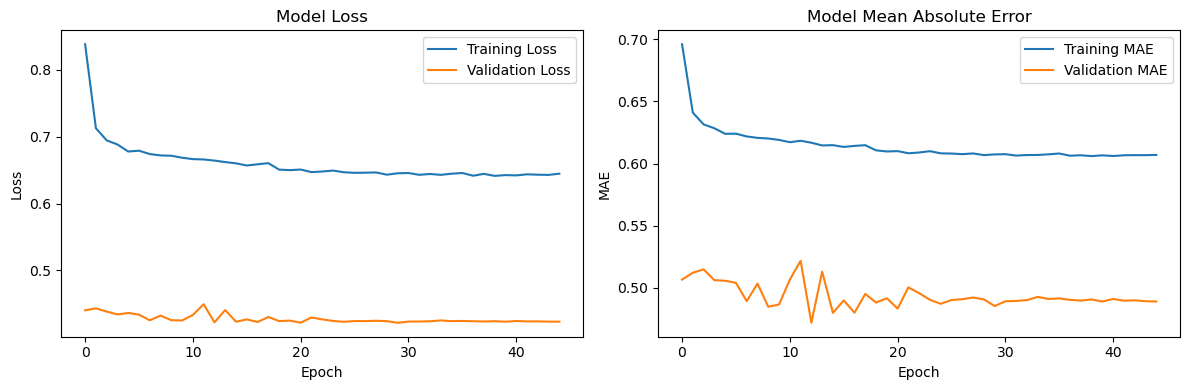

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
sequence_length = 10

# Prepare sequences
X, y, scaler = prepare_multi_player_sequences(
    df, 
    features=features, 
    sequence_length=sequence_length,
    min_games_per_player=40  # Adjust based on your dataset
)

# Train model
model, history = train_time_series_model(X, y)


Epoch 1/100


/Users/jamesstevens/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


478/478 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0326 - mae: 0.7707 - val_loss: 0.5242 - val_mae: 0.5566 - learning_rate: 0.0010
Epoch 2/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7184 - mae: 0.6461 - val_loss: 0.5143 - val_mae: 0.5454 - learning_rate: 0.0010
Epoch 3/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6983 - mae: 0.6359 - val_loss: 0.5186 - val_mae: 0.5516 - learning_rate: 0.0010
Epoch 4/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6871 - mae: 0.6304 - val_loss: 0.4980 - val_mae: 0.5333 - learning_rate: 0.0010
Epoch 5/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6759 - mae: 0.6240 - val_loss: 0.5005 - val_mae: 0.5316 - learning_rate: 0.0010
Epoch 6/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6706 - mae: 0.6200 - val_loss: 0.5078 - val_mae: 0.5392 - learning_rate: 0.0010
Epoch 7/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6628 - mae: 0.6177 - val_loss: 0.5038 - val_mae: 0.5344 - learning_rate: 0.0010
Epoch 8/100

In [19]:
sequence_length = 3

# Prepare sequences
X, y, scaler = prepare_multi_player_sequences(
    df, 
    features=features, 
    sequence_length=sequence_length,
    min_games_per_player=10  # Adjust based on your dataset
)

# Train model
model, history = train_time_series_model(X, y)

Epoch 1/100


/Users/jamesstevens/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0068 - mae: 0.7597 - val_loss: 0.4684 - val_mae: 0.5444 - learning_rate: 0.0010
Epoch 2/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7327 - mae: 0.6487 - val_loss: 0.4391 - val_mae: 0.5161 - learning_rate: 0.0010
Epoch 3/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7095 - mae: 0.6394 - val_loss: 0.4185 - val_mae: 0.4870 - learning_rate: 0.0010
Epoch 4/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6951 - mae: 0.6320 - val_loss: 0.4255 - val_mae: 0.4986 - learning_rate: 0.0010
Epoch 5/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6829 - mae: 0.6270 - val_loss: 0.4130 - val_mae: 0.4811 - learning_rate: 0.0010
Epoch 6/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6893 - mae: 0.6277 - val_loss: 0.4116 - val_mae: 0.4796 - learning_rate: 0.0010
Epoch 7/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6845 - mae: 0.6259 - val_loss: 0.4205 - val_mae: 0.4976 - learning_rate: 0.0010
Epoch 8/100

In [22]:
sequence_length = 3

# Prepare sequences
X, y, scaler = prepare_multi_player_sequences(
    df, 
    features=features, 
    sequence_length=sequence_length,
    min_games_per_player=3  # Adjust based on your dataset
)

# Train model
model, history = train_time_series_model(X, y)

Epoch 1/100


/Users/jamesstevens/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0525 - mae: 0.7802 - val_loss: 0.4386 - val_mae: 0.5148 - learning_rate: 0.0010
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7281 - mae: 0.6474 - val_loss: 0.4272 - val_mae: 0.5056 - learning_rate: 0.0010
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6984 - mae: 0.6336 - val_loss: 0.4114 - val_mae: 0.4757 - learning_rate: 0.0010
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7026 - mae: 0.6333 - val_loss: 0.4229 - val_mae: 0.5010 - learning_rate: 0.0010
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6901 - mae: 0.6270 - val_loss: 0.4188 - val_mae: 0.4918 - learning_rate: 0.0010
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6865 - mae: 0.6270 - val_loss: 0.4234 - val_mae: 0.5012 - learning_rate: 0.0010
Epoch 7/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6926 - mae: 0.6289 - val_loss: 0.4143 - val_mae: 0.4890 - learning_rate: 0.0010
Epoch 8/100

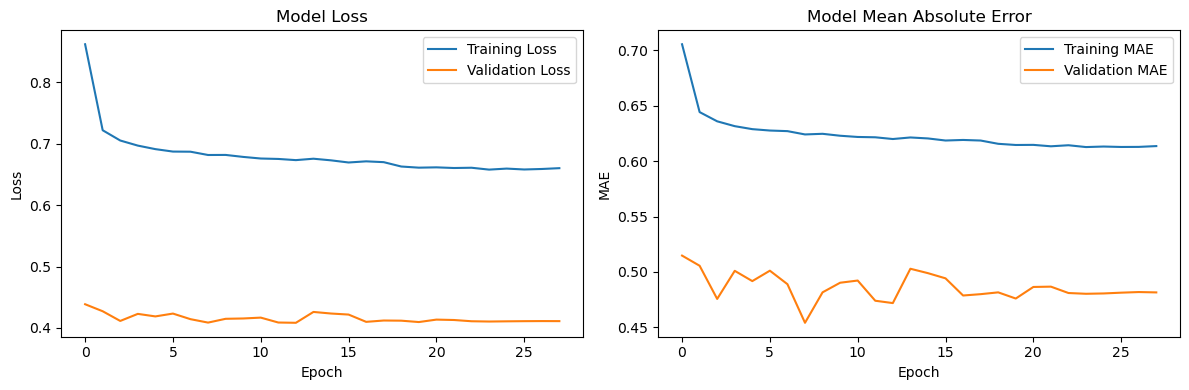

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/100


/Users/jamesstevens/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0299 - mae: 0.7690 - val_loss: 0.4305 - val_mae: 0.4961 - learning_rate: 0.0010
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7281 - mae: 0.6483 - val_loss: 0.4157 - val_mae: 0.4643 - learning_rate: 0.0010
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7063 - mae: 0.6360 - val_loss: 0.4253 - val_mae: 0.5004 - learning_rate: 0.0010
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6953 - mae: 0.6337 - val_loss: 0.4185 - val_mae: 0.4881 - learning_rate: 0.0010
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6895 - mae: 0.6287 - val_loss: 0.4178 - val_mae: 0.4915 - learning_rate: 0.0010
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6818 - mae: 0.6253 - val_loss: 0.4069 - val_mae: 0.4646 - learning_rate: 0.0010
Epoch 7/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6854 - mae: 0.6259 - val_loss: 0.4132 - val_mae: 0.4834 - learning_rate: 0.0010
Epoch 8/100

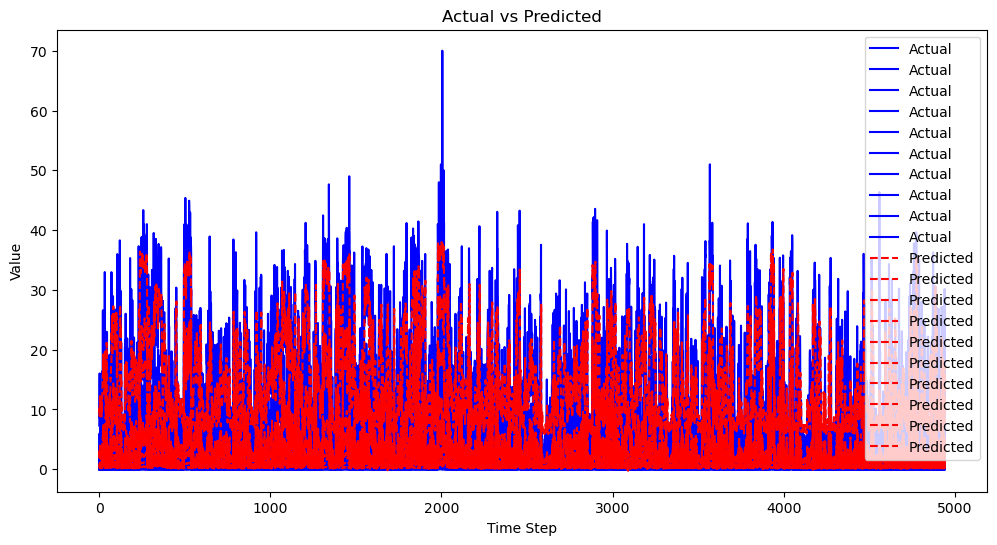

In [32]:
def train_time_series_model(X, y, test_size=0.2, epochs=100):
    """
    Train and evaluate time series model
    
    Args:
    - X: Input sequences
    - y: Target sequences
    - test_size: Proportion of data for validation
    - epochs: Maximum training epochs
    
    Returns:
    - Trained model
    - Training history
    - X_test
    - y_test
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    
    # Model and callbacks
    model = create_lstm_model(X.shape[1], X.shape[2])
    
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=0.00001
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return model, history, X_test, y_test

# Train model and get test sets
model, history, X_test, y_test = train_time_series_model(X, y)

# Make predictions
y_pred = model.predict(X_test)

# Rescale predictions and test values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Visualization of predictions vs actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
# Plot actual vs predicted values
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(y_pred_rescaled, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

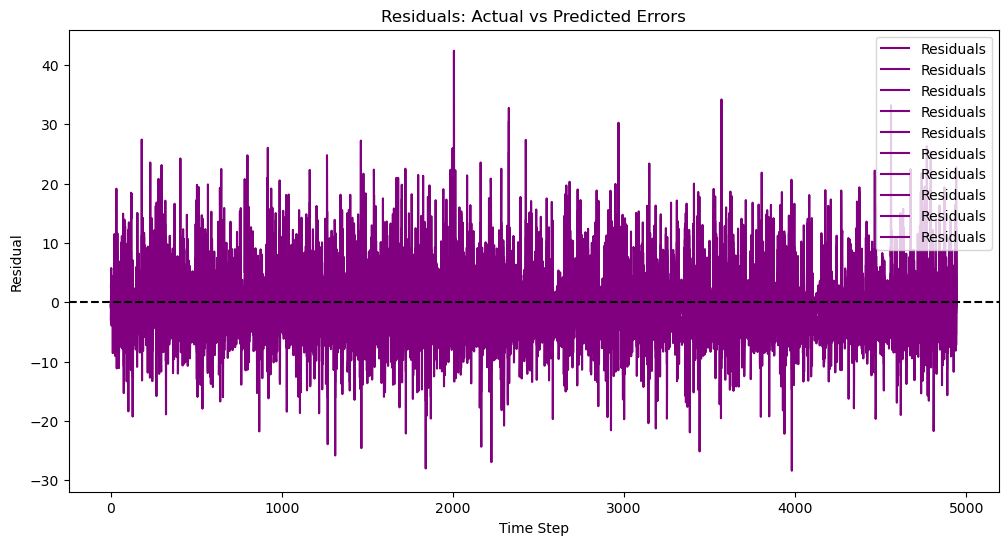

In [35]:
# Residuals: difference between actual and predicted values
residuals = y_test_rescaled - y_pred_rescaled

plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.title('Residuals: Actual vs Predicted Errors')
plt.legend()
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


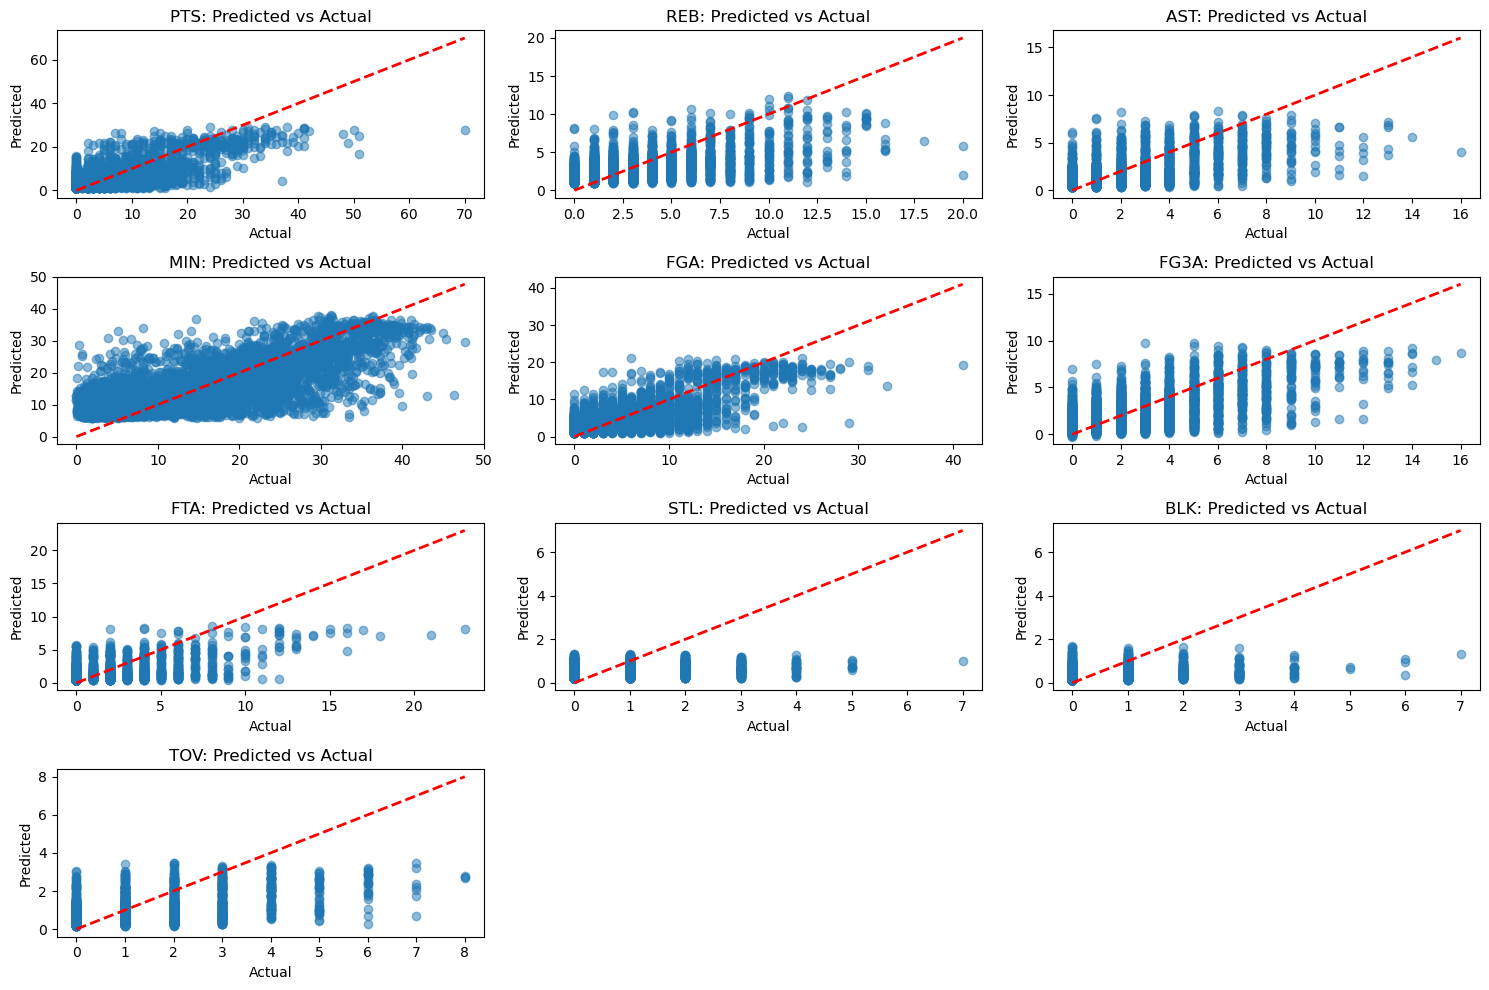

Detailed Feature-wise Metrics:

PTS:
  MAE: 3.6462
  MSE: 24.7200
  RMSE: 4.9719
  R2: 0.4988

REB:
  MAE: 1.6641
  MSE: 5.0100
  RMSE: 2.2383
  R2: 0.3558

AST:
  MAE: 1.0900
  MSE: 2.3054
  RMSE: 1.5183
  R2: 0.4152

MIN:
  MAE: 5.6769
  MSE: 51.3801
  RMSE: 7.1680
  R2: 0.5554

FGA:
  MAE: 2.4018
  MSE: 10.6505
  RMSE: 3.2635
  R2: 0.5735

FG3A:
  MAE: 1.2329
  MSE: 3.0412
  RMSE: 1.7439
  R2: 0.4981

FTA:
  MAE: 1.1954
  MSE: 2.7747
  RMSE: 1.6657
  R2: 0.3355

STL:
  MAE: 0.5696
  MSE: 0.5728
  RMSE: 0.7568
  R2: 0.0883

BLK:
  MAE: 0.4377
  MSE: 0.3862
  RMSE: 0.6215
  R2: 0.0912

TOV:
  MAE: 0.6767
  MSE: 0.8500
  RMSE: 0.9219
  R2: 0.3220


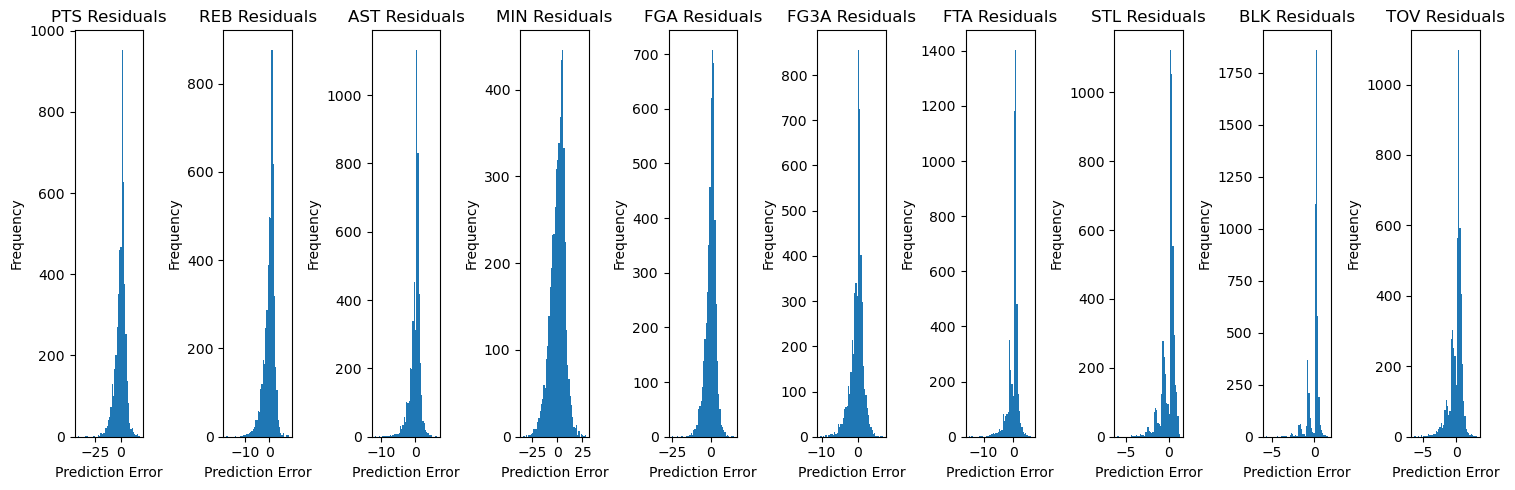

In [50]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model_predictions(model, X_test, y_test, scaler, features):
    """
    Comprehensive model evaluation function
    
    Args:
    - model: Trained LSTM model
    - X_test: Test input sequences
    - y_test: Test target sequences
    - scaler: Feature scaler used during preprocessing
    - features: List of feature names
    
    Returns:
    - Detailed evaluation metrics and visualizations
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test)
    
    # Compute evaluation metrics for each feature
    metrics = {}
    for i, feature in enumerate(features):
        mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
        mse = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])
        
        metrics[feature] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        }
    
    # Visualization: Predicted vs Actual for each feature
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features):
        plt.subplot(4, 3, i+1)
        plt.scatter(y_test_original[:, i], y_pred_original[:, i], alpha=0.5)
        plt.plot([y_test_original[:, i].min(), y_test_original[:, i].max()], 
                 [y_test_original[:, i].min(), y_test_original[:, i].max()], 
                 'r--', lw=2)
        plt.title(f'{feature}: Predicted vs Actual')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("Detailed Feature-wise Metrics:")
    for feature, metric in metrics.items():
        print(f"\n{feature}:")
        for metric_name, value in metric.items():
            print(f"  {metric_name}: {value:.4f}")
    
    # Residual plot for overall performance
    residuals = y_pred_original - y_test_original
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i+1)
        plt.hist(residuals[:, i], bins=50)
        plt.title(f'{feature} Residuals')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    return metrics, y_pred_original, y_test_original

# Prepare test data (same as in training script)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Evaluate the model
evaluation_metrics, predictions, actual = evaluate_model_predictions(
    model, X_test, y_test, scaler, features
)

In [66]:
def evaluate_by_player_segment(model, X_test, y_test, scaler, features, df):
    """
    Evaluate model performance across different player segments
    """
    y_pred = model.predict(X_test)
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test)
    
    # Ensure temp_df aligns with X_test and y_test
    temp_df = df.iloc[len(df) - len(y_test):].copy()
    
    # Segment by total minutes played
    temp_df['avg_minutes'] = temp_df.groupby('PLAYER_ID')['MIN'].transform('mean')
    
    # Create segments
    temp_df['minute_segment'] = pd.cut(
        temp_df['avg_minutes'], 
        bins=3, 
        labels=['Low', 'Medium', 'High']
    )
    
    print("Performance by Player Minute Segments:")
    for segment in ['Low', 'Medium', 'High']:
        print(f"\n{segment} Minutes Players:")
        
        # Find indices for this segment
        segment_indices = temp_df['minute_segment'] == segment
        
        # Filter predictions and actual values for this segment
        segment_indices = segment_indices.values  # Convert to numpy array to match dimensions
        segment_pred = y_pred_original[segment_indices]
        segment_actual = y_test_original[segment_indices]
        
        if len(segment_pred) > 0:
            for i, feature in enumerate(features):
                mae = mean_absolute_error(segment_actual[:, i], segment_pred[:, i])
                print(f"  {feature} MAE: {mae:.4f}")
        else:
            print(f"  {feature}: No data in this segment")


def prediction_intervals(y_pred, y_test, features, confidence=0.95):
    """
    Calculate prediction intervals
    """
    print("\nPrediction Intervals:")
    errors = np.abs(y_pred - y_test)
    
    for i, feature in enumerate(features):
        # Adjust confidence to percentiles
        lower_percentile = (1 - confidence) * 50
        upper_percentile = 100 - lower_percentile
        
        # Calculate intervals
        lower = np.percentile(errors[:, i], lower_percentile)
        median = np.percentile(errors[:, i], 50)
        upper = np.percentile(errors[:, i], upper_percentile)
        
        print(f"\n{feature}:")
        print(f"  {confidence*100}% Prediction Interval:")
        print(f"    Lower bound: {lower:.4f}")
        print(f"    Median error: {median:.4f}")
        print(f"    Upper bound: {upper:.4f}")

In [68]:
print("\n--- Player Segment Analysis ---")
evaluate_by_player_segment(model, X_test, y_test, scaler, features, df)

print("\n--- Prediction Intervals ---")
prediction_intervals(
    scaler.inverse_transform(model.predict(X_test)), 
    scaler.inverse_transform(y_test), 
    features
)


--- Player Segment Analysis ---
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
Performance by Player Minute Segments:

Low Minutes Players:
  PTS MAE: 3.5359
  REB MAE: 1.6081
  AST MAE: 1.1284
  MIN MAE: 5.6674
  FGA MAE: 2.3855
  FG3A MAE: 1.1884
  FTA MAE: 1.1272
  STL MAE: 0.5551
  BLK MAE: 0.4242
  TOV MAE: 0.6479

Medium Minutes Players:
  PTS MAE: 3.6337
  REB MAE: 1.6970
  AST MAE: 1.0871
  MIN MAE: 5.8383
  FGA MAE: 2.3984
  FG3A MAE: 1.2236
  FTA MAE: 1.2203
  STL MAE: 0.5531
  BLK MAE: 0.4380
  TOV MAE: 0.6616

High Minutes Players:
  PTS MAE: 3.7687
  REB MAE: 1.6682
  AST MAE: 1.0580
  MIN MAE: 5.4468
  FGA MAE: 2.4221
  FG3A MAE: 1.2886
  FTA MAE: 1.2228
  STL MAE: 0.6076
  BLK MAE: 0.4499
  TOV MAE: 0.7263

--- Prediction Intervals ---
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step

Prediction Intervals:

PTS:
  95.0% Prediction Interval:
    Lower bound: 0.1356
    Median error: 2.6659
    Upper bound: 12.5751

REB:
  95.0% Prediction Interval:
    Lower bound: 0.0800
    Medi

### Here we try to handle outliers... this proves to not be all that helpful.

In [70]:
import numpy as np
import pandas as pd

def handle_outliers(df, features, method='clip', threshold=1.5):
    """
    Handles outliers in the dataset based on the specified method.

    Args:
    - df (pd.DataFrame): Input data.
    - features (list): List of features to process.
    - method (str): 'clip' to cap values, 'remove' to filter out rows, 'log' to transform.
    - threshold (float): Multiplier for IQR to define outliers (default: 1.5).

    Returns:
    - pd.DataFrame: Processed DataFrame.
    """
    df_processed = df.copy()
    
    for feature in features:
        if method == 'clip':
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            df_processed[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
        
        elif method == 'remove':
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            df_processed = df_processed[
                (df_processed[feature] >= lower_bound) & 
                (df_processed[feature] <= upper_bound)
            ]
        
        elif method == 'log':
            # Apply log transformation (adding a small constant to avoid log(0))
            df_processed[feature] = np.log1p(df[feature])
    
    return df_processed

# Example Usage
outlier_features = ['PTS', 'MIN', 'FGA', 'FG3A', 'REB', 'AST']  # Features with high variability
df_cleaned = handle_outliers(df, features=outlier_features, method='clip')


In [72]:
# Example: Process high-minute players separately
minute_threshold = df['MIN'].quantile(0.75)  # Define threshold for "high minutes"
df_high_minutes = df[df['MIN'] >= minute_threshold]
df_low_minutes = df[df['MIN'] < minute_threshold]

# Apply outlier handling or transformations separately
df_high_minutes_cleaned = handle_outliers(df_high_minutes, features=outlier_features, method='clip')
df_low_minutes_cleaned = handle_outliers(df_low_minutes, features=outlier_features, method='clip')

# Combine back
df_combined = pd.concat([df_high_minutes_cleaned, df_low_minutes_cleaned])


In [76]:
sequence_length = 3

# Prepare sequences
X, y, scaler = prepare_multi_player_sequences(
    df_combined, 
    features=features, 
    sequence_length=sequence_length,
    min_games_per_player=4  # Adjust based on your dataset
)

# Train model
model, history = train_time_series_model(X, y)

Epoch 1/100


/Users/jamesstevens/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0275 - mae: 0.7713 - val_loss: 0.4606 - val_mae: 0.5319 - learning_rate: 0.0010
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7339 - mae: 0.6526 - val_loss: 0.4202 - val_mae: 0.4857 - learning_rate: 0.0010
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7063 - mae: 0.6403 - val_loss: 0.4379 - val_mae: 0.5164 - learning_rate: 0.0010
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7000 - mae: 0.6388 - val_loss: 0.4380 - val_mae: 0.5203 - learning_rate: 0.0010
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6978 - mae: 0.6372 - val_loss: 0.4251 - val_mae: 0.5012 - learning_rate: 0.0010
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6861 - mae: 0.6308 - val_loss: 0.4231 - val_mae: 0.4956 - learning_rate: 0.0010
Epoch 7/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6808 - mae: 0.6283 - val_loss: 0.4286 - val_mae: 0.5099 - learning_rate: 0.0010
Epoch 8/100

ValueError: too many values to unpack (expected 2)

In [79]:
learn.export('statForecast.pkl')

NameError: name 'learn' is not defined

In [81]:
# Assuming 'model' is your trained Keras model
model.save('my_model.h5')  # Save in HDF5 format

In [83]:
model.save('my_model.keras')  # Save in HDF5 format

In [87]:
X_test[0]

array([[-0.74050101, -0.88215181, -0.55836373, -1.58293604, -1.01798626,
        -1.07169577, -0.73589519, -0.74421546, -0.55973912, -0.87850873],
       [-0.6291802 , -0.88215181, -0.55836373, -1.20429266, -1.01798626,
        -1.07169577,  0.71716241, -0.74421546, -0.55973912, -0.87850873],
       [-0.74050101, -1.17037022, -0.93381888, -1.20729776, -1.01798626,
        -1.07169577, -0.73589519,  1.39114812, -0.55973912, -0.14827327]])

In [107]:
model.predict(np.array([[[10,5,3,15,10,3,3,1,1,3],[9,12,4,25,5,2,4,2,0,3],[15,7,6,20,15,3,10,0,2,3]]]).reshape(1,3,10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


array([[ 0.8942859 ,  0.21504034,  0.5145442 ,  1.0833482 ,  1.0514964 ,
         1.2254918 ,  0.42837164,  0.3478578 , -0.05225448,  0.48049405]],
      dtype=float32)

In [112]:
sequence_length=4

In [114]:
# Prepare sequences
X, y, scaler = prepare_multi_player_sequences(
    df, 
    features=features, 
    sequence_length=sequence_length,
    min_games_per_player=4  # Adjust based on your dataset
)

# Train model
model, history = train_time_series_model(X, y)

Epoch 1/100


/Users/jamesstevens/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0329 - mae: 0.7706 - val_loss: 0.4534 - val_mae: 0.5322 - learning_rate: 0.0010
Epoch 2/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7218 - mae: 0.6449 - val_loss: 0.4172 - val_mae: 0.4860 - learning_rate: 0.0010
Epoch 3/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7013 - mae: 0.6335 - val_loss: 0.4154 - val_mae: 0.4842 - learning_rate: 0.0010
Epoch 4/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6924 - mae: 0.6304 - val_loss: 0.4164 - val_mae: 0.4886 - learning_rate: 0.0010
Epoch 5/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6894 - mae: 0.6261 - val_loss: 0.4191 - val_mae: 0.4941 - learning_rate: 0.0010
Epoch 6/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6839 - mae: 0.6243 - val_loss: 0.4067 - val_mae: 0.4702 - learning_rate: 0.0010
Epoch 7/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6759 - mae: 0.6221 - val_loss: 0.4170 - val_mae: 0.4906 - learning_rate: 0.0010
Epoch 8/100

ValueError: too many values to unpack (expected 2)